# Problem 2.  Understanding Performance Tunning for Training High Accuracy Deep or Shallow Models

## Problem 1.1 Performance Tunning for Deep or Shallow Learning 

- Framework used TensorFlow and the library I used was Keras
- Machine Learning Model: Bidirectional LSTM
- Dataset: [IMDB Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/)


### Import the Libraries

In [2]:
import os
import sys
import time

import numpy as np

import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

## Data loading

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteQWOXLA/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteQWOXLA/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteQWOXLA/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [46]:
print(len(list(train_dataset)))
print(len(list(test_dataset)))

391
391


### Example datapoints

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
# Shuffle the data

BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [193]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy()[:3])
  print('label: ', label.numpy()[:3])

text:  [b"Kirk and crew land on a lonely planet where the sun is about to explode. They intend to evacuate the inhabitants but find the place deserted except for a Mr. Atoz who operates some sort of high-tech library. Despite trying to get a straight answer from him about everyone's whereabouts, Atoz is indifferent to their questions and insist they must quickly 'make a selection while there is still time'. They have no idea what he's talking about but wander about looking at the hand mirror-like disks on the viewers and they see images of the planet's past. Then, while a disk is in the viewer, Kirk runs through the doorway and is magically transported back in time to what on Earth would look like the time of Louis XIV (the 1660s). When McCoy and Spock follow, a different disk is in the viewer and they are sent to an ice age hell. All too late they realize that the library is a time travel machine and repository.<br /><br />While Kirk's visit is pretty short and not all that exciting, 

### Data Preprocessing and text encoding

In [10]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [11]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [12]:
encoded_example = encoder(example)[:5].numpy()
encoded_example.shape

(5, 953)

### Create the LSTM Model

In [13]:
model_base = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])  # Can change the embedding initializer and in fact
    #all the other hyperparameters in the various layers

In [14]:
model_base.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### Train the model

In [15]:
def train_model(model_inst):
    start_time = time.time()

    history = model_inst.fit(train_dataset, epochs=10,
                        validation_data=test_dataset,
                        validation_steps=30)

    end_time = time.time()

    mins = (end_time-start_time)/60
    secs = (end_time-start_time)%60

    print("Time taken to train: {} minutes and {} seconds".format(mins, secs))
    return model_inst, history

In [18]:
model_base, history_base = train_model(model_base)

Epoch 1/10
391/391 [==============================] - 32s 81ms/step - loss: 0.3381 - accuracy: 0.8555 - val_loss: 0.3399 - val_accuracy: 0.8542
Epoch 2/10
391/391 [==============================] - 33s 82ms/step - loss: 0.3247 - accuracy: 0.8635 - val_loss: 0.3439 - val_accuracy: 0.8448
Epoch 3/10
391/391 [==============================] - 33s 82ms/step - loss: 0.3164 - accuracy: 0.8688 - val_loss: 0.3283 - val_accuracy: 0.8536
Epoch 4/10
391/391 [==============================] - 32s 82ms/step - loss: 0.3103 - accuracy: 0.8704 - val_loss: 0.3285 - val_accuracy: 0.8578
Epoch 5/10
391/391 [==============================] - 32s 82ms/step - loss: 0.3076 - accuracy: 0.8712 - val_loss: 0.3254 - val_accuracy: 0.8547
Epoch 6/10
391/391 [==============================] - 33s 82ms/step - loss: 0.3042 - accuracy: 0.8727 - val_loss: 0.3228 - val_accuracy: 0.8536
Epoch 7/10
391/391 [==============================] - 32s 82ms/step - loss: 0.3041 - accuracy: 0.8716 - val_loss: 0.3206 - val_accuracy:

### Test the model

In [20]:
def test_model(model_inst):
    start_time = time.time()
    test_loss, test_acc = model_inst.evaluate(test_dataset)
    end_time = time.time()

    mins = (end_time-start_time)/60
    secs = (end_time-start_time)%60

    print("Time taken to test: {} minutes and {} seconds".format(mins, secs))

    print('Test Loss:', test_loss)
    print('Test Accuracy:', test_acc)

In [21]:
test_model(model_base)

391/391 [==============================] - 19s 49ms/step - loss: 0.3142 - accuracy: 0.8608
Time taken to test: 0.32047993342081704 minutes and 19.228796005249023 seconds
Test Loss: 0.31423330307006836
Test Accuracy: 0.86080002784729


### Confusion Matrix

In [22]:
def get_confusion_matrix(model_inst):
    y_pred = []
    y_true = []

    for x, y in test_dataset:
        preds = model_inst.predict([x])
        y_pred.extend(preds.flatten().tolist())
        y_true.extend(y.numpy().tolist())

    y_pred = [1 if i>0 else 0 for i in y_pred]
    conf_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
    print(conf_matrix)

In [23]:
get_confusion_matrix(model_base)

[[10754  1746]
 [ 1661 10839]]


#### Train and Validation plots

In [24]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [25]:
def make_plot(history):
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plot_graphs(history, 'accuracy')
    plt.ylim(None, 1)
    plt.subplot(1, 2, 2)
    plot_graphs(history, 'loss')
    plt.ylim(0, None)

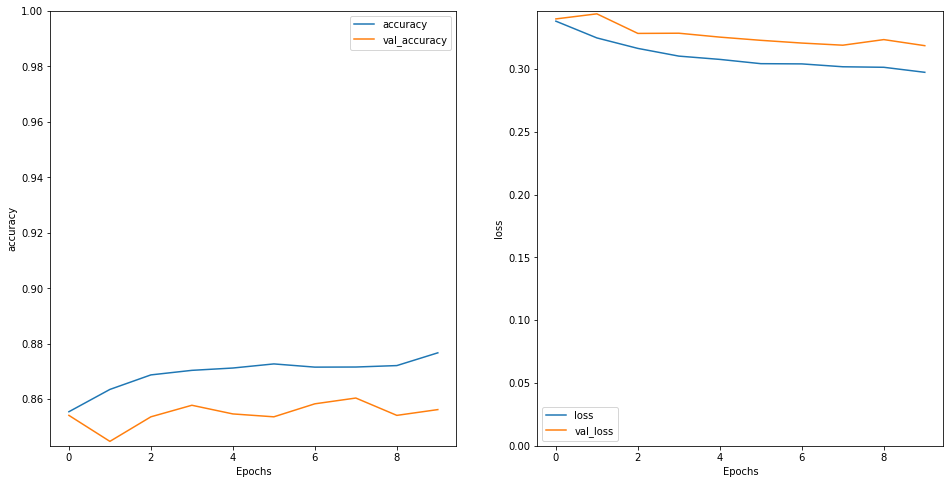

In [26]:
make_plot(history_base)

### Model storage size and summary

In [27]:
model_base.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 138,369
Trainable params: 138,369
Non-trainable params: 0
__________________________________________________

In [28]:
model_base.save('drive/MyDrive/GaTech/big_data/model_base')

INFO:tensorflow:Assets written to: drive/MyDrive/GaTech/big_data/model_base/assets


INFO:tensorflow:Assets written to: drive/MyDrive/GaTech/big_data/model_base/assets


In [29]:
!du -hsx drive/MyDrive/GaTech/big_data/model_base

8.5M	drive/MyDrive/GaTech/big_data/model_base


### Out of Distribution data prediction

In [30]:
for example, label in test_dataset.take(1):
  print('text: ', example.numpy()[:10])
  print('label: ', label.numpy()[:10])

text:  [b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come."
 b"A blackly comic tale of a down-trodden priest,

#### OOD Datapoints:
- Dataset link: https://arxiv.org/pdf/2012.10289.pdf

In [31]:
oods = [
        "lol what a stupid kike",
        "watching the rugby game and the entire other team has long hair this feels antithetical to the dyke ethos of it all",
        "folks i do not wana be greedy so today i ama start da same program i had on twitter so here it is da first nigger who can retweet dis go win a free cup of shit to eat ok go",
        "that not a compliment a compliment is you are sexy you turn me on not not one look at you and i know i am queer",
        "every kike needs to be baptised",
        "non white and kike we are coming for you a white revolution is on its way",
        "hunger games with little niglet babies",
        "stupid meme delete now dont you dare put a kike on the boss face not even joking delete now",
        "meanwhile an entire company gets shutdown for diversity training because two coons decided to loiter and then refuse police orders to disperse that called privilege and blacks have it",
        "on a bus not one single english person plus one coon talking on the phone in some gibberish language i do not understand"
]

In [32]:
for ood in oods:
    pred = model_base.predict([ood])
    print("Prediction confidence : {}".format(pred))

Prediction confidence : [[-0.9284324]]
Prediction confidence : [[-0.00087826]]
Prediction confidence : [[-0.83982784]]
Prediction confidence : [[-0.354468]]
Prediction confidence : [[0.09274442]]
Prediction confidence : [[1.187999]]
Prediction confidence : [[0.1415203]]
Prediction confidence : [[-1.0073317]]
Prediction confidence : [[-0.7593328]]
Prediction confidence : [[-0.91483915]]


#### Prediction confidence in test set

In [33]:
for example, label in test_dataset.take(1):
    preds = model_base.predict([example.numpy()[:10]])
    print('text: ', example.numpy()[:10])
    print('label: ', label.numpy()[:10])
    print("Predictions: {}".format(preds.flatten()))

text:  [b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come."
 b"A blackly comic tale of a down-trodden priest,

### Create the Stacked LSTM Model

In [34]:
model_stk = tf.keras.Sequential([
encoder,
tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1)
])

In [35]:
model_stk.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### Train the stacked LSTM model

In [37]:
model_stk, history_stk = train_model(model_stk)

Epoch 1/10
391/391 [==============================] - 60s 151ms/step - loss: 0.4417 - accuracy: 0.7903 - val_loss: 0.3631 - val_accuracy: 0.8385
Epoch 2/10
391/391 [==============================] - 55s 140ms/step - loss: 0.3491 - accuracy: 0.8514 - val_loss: 0.4092 - val_accuracy: 0.7943
Epoch 3/10
391/391 [==============================] - 55s 139ms/step - loss: 0.3273 - accuracy: 0.8612 - val_loss: 0.3260 - val_accuracy: 0.8469
Epoch 4/10
391/391 [==============================] - 55s 140ms/step - loss: 0.3145 - accuracy: 0.8655 - val_loss: 0.3196 - val_accuracy: 0.8651
Epoch 5/10
391/391 [==============================] - 55s 139ms/step - loss: 0.3103 - accuracy: 0.8672 - val_loss: 0.3210 - val_accuracy: 0.8641
Epoch 6/10
391/391 [==============================] - 55s 139ms/step - loss: 0.3077 - accuracy: 0.8681 - val_loss: 0.3158 - val_accuracy: 0.8568
Epoch 7/10
391/391 [==============================] - 55s 139ms/step - loss: 0.3044 - accuracy: 0.8698 - val_loss: 0.3162 - val_ac

### Test the stacked LSTM model

In [38]:
test_model(model_stk)

391/391 [==============================] - 29s 74ms/step - loss: 0.3319 - accuracy: 0.8292
Time taken to test: 0.4824146707852682 minutes and 28.94488024711609 seconds
Test Loss: 0.3319109380245209
Test Accuracy: 0.8291599750518799


### Confusion Matrix

In [39]:
get_confusion_matrix(model_stk)

[[11360  1140]
 [ 2561  9939]]


### Train and Validation Plot

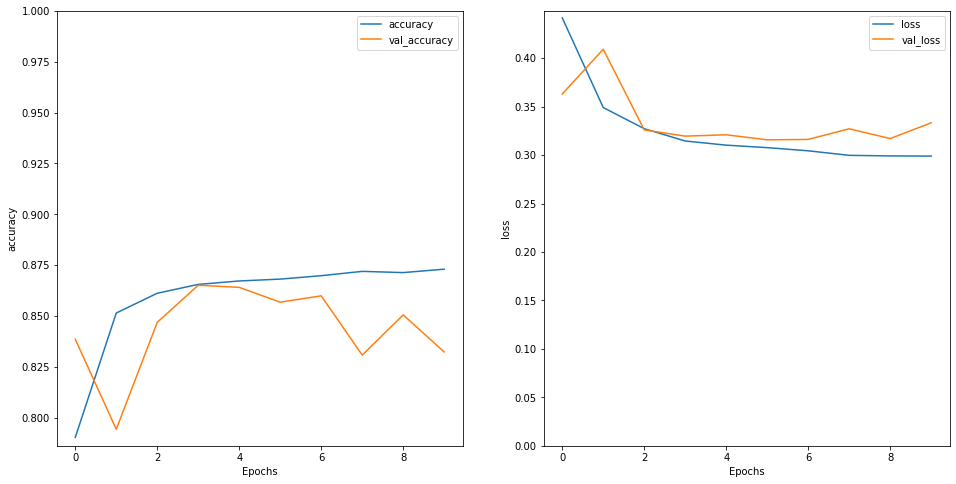

In [40]:
make_plot(history_stk)

### Model storage size and summary

In [41]:
model_stk.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [43]:
model_stk.save('drive/MyDrive/GaTech/big_data/model_stk')

INFO:tensorflow:Assets written to: drive/MyDrive/GaTech/big_data/model_stk/assets


INFO:tensorflow:Assets written to: drive/MyDrive/GaTech/big_data/model_stk/assets


In [47]:
!du -hsx drive/MyDrive/GaTech/big_data/model_stk

16M	drive/MyDrive/GaTech/big_data/model_stk


### Create the Stacked LSTM Model with high LR



In [48]:
model_stk_lr = tf.keras.Sequential([
encoder,
tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1)
])

In [49]:
model_stk_lr.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=['accuracy'])

### Train the stacked LSTM model with high LR

In [50]:
model_stk_lr, history_stk_lr = train_model(model_stk_lr)

Epoch 1/10
391/391 [==============================] - 71s 152ms/step - loss: 0.5684 - accuracy: 0.6809 - val_loss: 0.4018 - val_accuracy: 0.8042
Epoch 2/10
391/391 [==============================] - 56s 141ms/step - loss: 0.3657 - accuracy: 0.8389 - val_loss: 0.3264 - val_accuracy: 0.8453
Epoch 3/10
391/391 [==============================] - 56s 142ms/step - loss: 0.3177 - accuracy: 0.8607 - val_loss: 0.3103 - val_accuracy: 0.8542
Epoch 4/10
391/391 [==============================] - 55s 140ms/step - loss: 0.2870 - accuracy: 0.8738 - val_loss: 0.3049 - val_accuracy: 0.8620
Epoch 5/10
391/391 [==============================] - 55s 140ms/step - loss: 0.2683 - accuracy: 0.8837 - val_loss: 0.3068 - val_accuracy: 0.8542
Epoch 6/10
391/391 [==============================] - 55s 140ms/step - loss: 0.2537 - accuracy: 0.8893 - val_loss: 0.3165 - val_accuracy: 0.8609
Epoch 7/10
391/391 [==============================] - 55s 138ms/step - loss: 0.2406 - accuracy: 0.8970 - val_loss: 0.3383 - val_ac

### Test the stacked LSTM model with high LR

In [51]:
test_model(model_stk_lr)

391/391 [==============================] - 29s 75ms/step - loss: 0.3189 - accuracy: 0.8513
Time taken to test: 0.48798237641652426 minutes and 29.278942584991455 seconds
Test Loss: 0.31893521547317505
Test Accuracy: 0.8512799739837646


### Confusion Matrix

In [52]:
get_confusion_matrix(model_stk_lr)

[[11359  1141]
 [ 2190 10310]]


### Train and Validation Plot

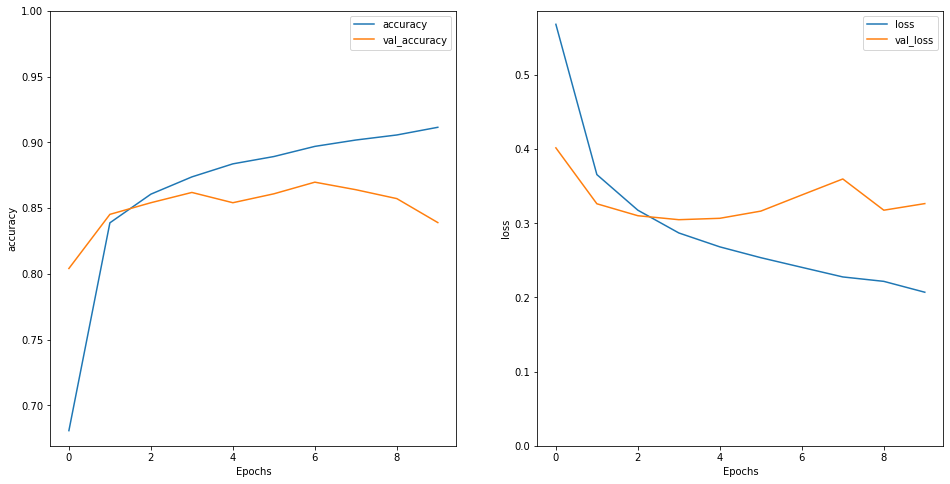

In [53]:
make_plot(history_stk_lr)

### Model storage size and summary

In [54]:
model_stk_lr.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [55]:
model_stk_lr.save('drive/MyDrive/GaTech/big_data/model_stk_lr')

INFO:tensorflow:Assets written to: drive/MyDrive/GaTech/big_data/model_stk_lr/assets


INFO:tensorflow:Assets written to: drive/MyDrive/GaTech/big_data/model_stk_lr/assets


In [56]:
!du -hsx drive/MyDrive/GaTech/big_data/model_stk_lr

16M	drive/MyDrive/GaTech/big_data/model_stk_lr


### Create the high encoding dim LSTM Model with normal LR



In [57]:
model_stk_enc = tf.keras.Sequential([
encoder,
tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1)
])

In [58]:
model_stk_enc.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### Train the stacked LSTM model with high LR

In [59]:
model_stk_enc, history_stk_enc = train_model(model_stk_enc)

Epoch 1/10
391/391 [==============================] - 83s 181ms/step - loss: 0.5550 - accuracy: 0.6624 - val_loss: 0.3659 - val_accuracy: 0.8453
Epoch 2/10
391/391 [==============================] - 68s 172ms/step - loss: 0.3497 - accuracy: 0.8456 - val_loss: 0.3300 - val_accuracy: 0.8458
Epoch 3/10
391/391 [==============================] - 66s 169ms/step - loss: 0.3216 - accuracy: 0.8624 - val_loss: 0.3236 - val_accuracy: 0.8547
Epoch 4/10
391/391 [==============================] - 67s 170ms/step - loss: 0.3105 - accuracy: 0.8670 - val_loss: 0.3199 - val_accuracy: 0.8609
Epoch 5/10
391/391 [==============================] - 66s 168ms/step - loss: 0.3053 - accuracy: 0.8695 - val_loss: 0.3267 - val_accuracy: 0.8615
Epoch 6/10
391/391 [==============================] - 66s 168ms/step - loss: 0.3023 - accuracy: 0.8697 - val_loss: 0.3168 - val_accuracy: 0.8536
Epoch 7/10
391/391 [==============================] - 67s 169ms/step - loss: 0.2957 - accuracy: 0.8718 - val_loss: 0.3276 - val_ac

### Test the stacked LSTM model

In [60]:
test_model(model_stk_enc)

391/391 [==============================] - 33s 83ms/step - loss: 0.3159 - accuracy: 0.8570
Time taken to test: 0.5421261548995971 minutes and 32.52756929397583 seconds
Test Loss: 0.3158969283103943
Test Accuracy: 0.8569599986076355


### Confusion Matrix

In [61]:
get_confusion_matrix(model_stk_enc)

[[10946  1554]
 [ 1809 10691]]


### Train and Validation Plot

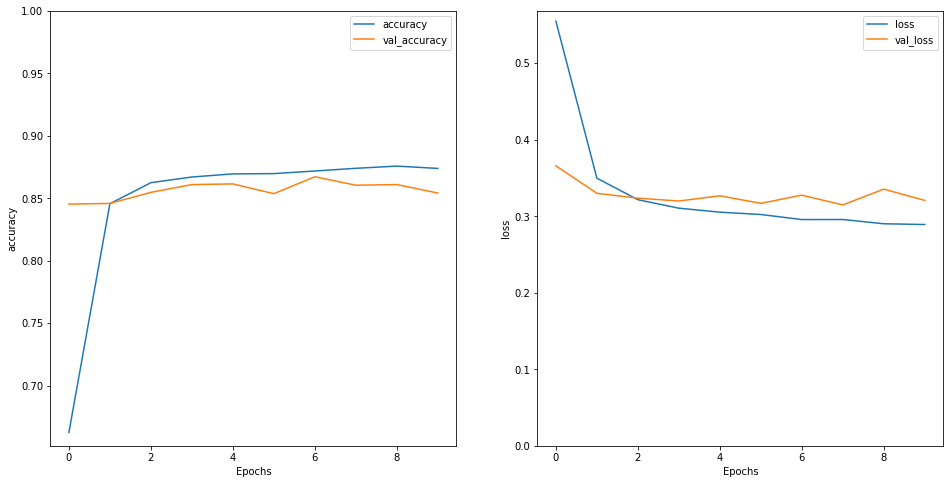

In [62]:
make_plot(history_stk_enc)

### Model storage size and summary

In [63]:
model_stk_enc.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 128)         128000    
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 256)         263168    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [64]:
model_stk_enc.save('drive/MyDrive/GaTech/big_data/model_stk_enc')

INFO:tensorflow:Assets written to: drive/MyDrive/GaTech/big_data/model_stk_enc/assets


INFO:tensorflow:Assets written to: drive/MyDrive/GaTech/big_data/model_stk_enc/assets


In [65]:
!du -hsx drive/MyDrive/GaTech/big_data/model_stk_enc

21M	drive/MyDrive/GaTech/big_data/model_stk_enc


### Create the high encoding dim LSTM Model with high LR



In [66]:
model_stk_enc_lr = tf.keras.Sequential([
encoder,
tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1)
])

In [67]:
model_stk_enc_lr.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=['accuracy'])

### Train the stacked LSTM model with high LR

In [68]:
model_stk_enc_lr, history_stk_enc_lr = train_model(model_stk_enc_lr)

Epoch 1/10
391/391 [==============================] - 81s 178ms/step - loss: 0.5463 - accuracy: 0.6870 - val_loss: 0.4041 - val_accuracy: 0.8161
Epoch 2/10
391/391 [==============================] - 66s 168ms/step - loss: 0.4153 - accuracy: 0.8105 - val_loss: 0.3756 - val_accuracy: 0.8250
Epoch 3/10
391/391 [==============================] - 66s 168ms/step - loss: 0.3681 - accuracy: 0.8334 - val_loss: 0.3632 - val_accuracy: 0.8078
Epoch 4/10
391/391 [==============================] - 66s 167ms/step - loss: 0.3389 - accuracy: 0.8452 - val_loss: 0.3518 - val_accuracy: 0.8047
Epoch 5/10
391/391 [==============================] - 67s 169ms/step - loss: 0.3385 - accuracy: 0.8527 - val_loss: 0.3381 - val_accuracy: 0.8469
Epoch 6/10
391/391 [==============================] - 66s 167ms/step - loss: 0.3117 - accuracy: 0.8618 - val_loss: 0.3186 - val_accuracy: 0.8599
Epoch 7/10
391/391 [==============================] - 66s 169ms/step - loss: 0.3050 - accuracy: 0.8629 - val_loss: 0.3294 - val_ac

### Test the stacked LSTM model

In [69]:
test_model(model_stk_enc_lr)

391/391 [==============================] - 32s 83ms/step - loss: 0.3207 - accuracy: 0.8521
Time taken to test: 0.5396168788274129 minutes and 32.377012729644775 seconds
Test Loss: 0.3207297921180725
Test Accuracy: 0.8521199822425842


### Confusion Matrix

In [70]:
get_confusion_matrix(model_stk_enc_lr)

[[10764  1736]
 [ 1663 10837]]


### Train and Validation Plot

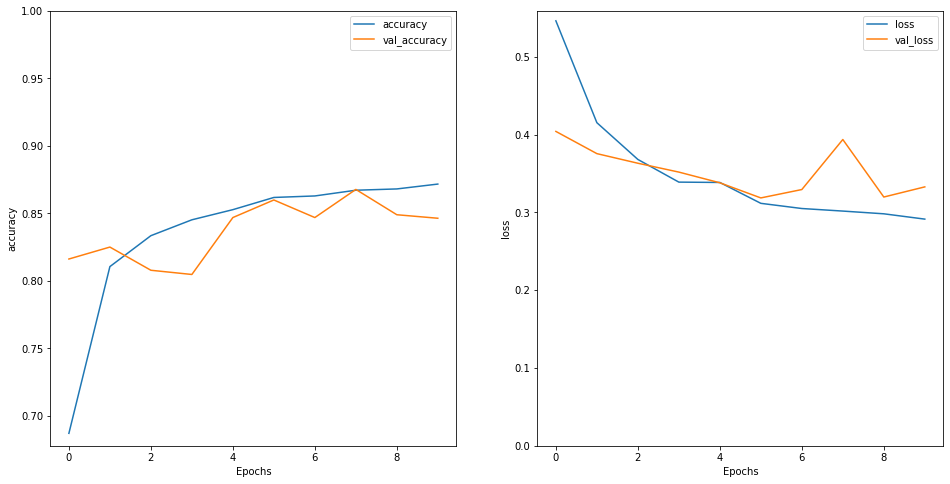

In [71]:
make_plot(history_stk_enc_lr)

### Model storage size and summary

In [82]:
model_stk_enc_lr.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 128)         128000    
_________________________________________________________________
bidirectional_7 (Bidirection (None, None, 256)         263168    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [83]:
model_stk_enc_lr.save('drive/MyDrive/GaTech/big_data/model_stk_enc_lr')

INFO:tensorflow:Assets written to: drive/MyDrive/GaTech/big_data/model_stk_enc_lr/assets


INFO:tensorflow:Assets written to: drive/MyDrive/GaTech/big_data/model_stk_enc_lr/assets


In [84]:
!du -hsx drive/MyDrive/GaTech/big_data/model_stk_enc_lr

21M	drive/MyDrive/GaTech/big_data/model_stk_enc_lr


### OOD analysis

In [96]:
model_ood1 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])  # Can change the embedding initializer and in fact
    #all the other hyperparameters in the various layers

In [97]:
model_ood1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [98]:
start_time = time.time()

history = model_ood1.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

end_time = time.time()

mins = (end_time-start_time)/60
secs = (end_time-start_time)%60

print("Time taken to train: {} minutes and {} seconds".format(mins, secs))

Epoch 1/5
391/391 [==============================] - 45s 90ms/step - loss: 0.6655 - accuracy: 0.5388 - val_loss: 0.5378 - val_accuracy: 0.7120
Epoch 2/5
391/391 [==============================] - 34s 85ms/step - loss: 0.4470 - accuracy: 0.7970 - val_loss: 0.3869 - val_accuracy: 0.8469
Epoch 3/5
391/391 [==============================] - 34s 85ms/step - loss: 0.3564 - accuracy: 0.8450 - val_loss: 0.3438 - val_accuracy: 0.8411
Epoch 4/5
391/391 [==============================] - 34s 86ms/step - loss: 0.3363 - accuracy: 0.8594 - val_loss: 0.3310 - val_accuracy: 0.8578
Epoch 5/5
391/391 [==============================] - 34s 86ms/step - loss: 0.3241 - accuracy: 0.8653 - val_loss: 0.3289 - val_accuracy: 0.8557
Time taken to train: 3.3168219327926636 minutes and 19.009315967559814 seconds


In [100]:
model_ood2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])  # Can change the embedding initializer and in fact
    #all the other hyperparameters in the various layers

In [101]:
model_ood2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [103]:
start_time = time.time()

history = model_ood2.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

end_time = time.time()

mins = (end_time-start_time)/60
secs = (end_time-start_time)%60

print("Time taken to train: {} minutes and {} seconds".format(mins, secs))

Epoch 1/5
391/391 [==============================] - 41s 90ms/step - loss: 0.6702 - accuracy: 0.5352 - val_loss: 0.5841 - val_accuracy: 0.6453
Epoch 2/5
391/391 [==============================] - 33s 84ms/step - loss: 0.5009 - accuracy: 0.7609 - val_loss: 0.4631 - val_accuracy: 0.8224
Epoch 3/5
391/391 [==============================] - 34s 85ms/step - loss: 0.4028 - accuracy: 0.8247 - val_loss: 0.3727 - val_accuracy: 0.8385
Epoch 4/5
391/391 [==============================] - 33s 84ms/step - loss: 0.3668 - accuracy: 0.8431 - val_loss: 0.3495 - val_accuracy: 0.8500
Epoch 5/5
391/391 [==============================] - 33s 84ms/step - loss: 0.3406 - accuracy: 0.8569 - val_loss: 0.3361 - val_accuracy: 0.8448
Time taken to train: 3.004755127429962 minutes and 0.2853076457977295 seconds


In [106]:
model_ood3 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])  # Can change the embedding initializer and in fact
    #all the other hyperparameters in the various layers

In [107]:
model_ood3.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [108]:
start_time = time.time()

history = model_ood3.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

end_time = time.time()

mins = (end_time-start_time)/60
secs = (end_time-start_time)%60

print("Time taken to train: {} minutes and {} seconds".format(mins, secs))

Epoch 1/5
391/391 [==============================] - 41s 90ms/step - loss: 0.6759 - accuracy: 0.5236 - val_loss: 0.5790 - val_accuracy: 0.6464
Epoch 2/5
391/391 [==============================] - 33s 84ms/step - loss: 0.4715 - accuracy: 0.7746 - val_loss: 0.3944 - val_accuracy: 0.8281
Epoch 3/5
391/391 [==============================] - 33s 84ms/step - loss: 0.3671 - accuracy: 0.8396 - val_loss: 0.3646 - val_accuracy: 0.8490
Epoch 4/5
391/391 [==============================] - 33s 84ms/step - loss: 0.3424 - accuracy: 0.8551 - val_loss: 0.3603 - val_accuracy: 0.8516
Epoch 5/5
391/391 [==============================] - 33s 84ms/step - loss: 0.3272 - accuracy: 0.8602 - val_loss: 0.3316 - val_accuracy: 0.8594
Time taken to train: 3.1672158082326254 minutes and 10.03294849395752 seconds


In [104]:
test_model(model_ood1)

391/391 [==============================] - 19s 48ms/step - loss: 0.3191 - accuracy: 0.8604
Time taken to test: 0.3147871692975362 minutes and 18.887230157852173 seconds
Test Loss: 0.3190709054470062
Test Accuracy: 0.8603600263595581


In [105]:
test_model(model_ood2)

391/391 [==============================] - 19s 48ms/step - loss: 0.3308 - accuracy: 0.8502
Time taken to test: 0.31311646302541096 minutes and 18.786987781524658 seconds
Test Loss: 0.33075854182243347
Test Accuracy: 0.8501600027084351


In [109]:
test_model(model_ood3)

391/391 [==============================] - 19s 48ms/step - loss: 0.3231 - accuracy: 0.8626
Time taken to test: 0.3139250795046488 minutes and 18.83550477027893 seconds
Test Loss: 0.3230810761451721
Test Accuracy: 0.8626400232315063


In [110]:
for ood in oods:
    pred = model_ood1.predict([ood])
    print("Prediction confidence : {}".format(pred))

Prediction confidence : [[-0.7000556]]
Prediction confidence : [[0.03726222]]
Prediction confidence : [[-0.44067633]]
Prediction confidence : [[0.03025485]]
Prediction confidence : [[-0.27860233]]
Prediction confidence : [[0.7900459]]
Prediction confidence : [[-0.00195041]]
Prediction confidence : [[-0.9899855]]
Prediction confidence : [[-0.89603573]]
Prediction confidence : [[-0.60025364]]


#### Prediction confidence in test set

In [113]:
for example, label in test_dataset.take(1):
    preds = model_ood1.predict([example.numpy()[:10]])
    print('text: ', example.numpy()[:10])
    print('label: ', label.numpy()[:10])
    print("Predictions: {}".format(preds.flatten()))

text:  [b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come."
 b"A blackly comic tale of a down-trodden priest,

In [111]:
for ood in oods:
    pred = model_ood2.predict([ood])
    print("Prediction confidence : {}".format(pred))

Prediction confidence : [[-0.73920035]]
Prediction confidence : [[-0.1974909]]
Prediction confidence : [[-0.7825821]]
Prediction confidence : [[-0.11924624]]
Prediction confidence : [[-0.25618345]]
Prediction confidence : [[0.67674327]]
Prediction confidence : [[-0.12907374]]
Prediction confidence : [[-0.9427591]]
Prediction confidence : [[-0.6618499]]
Prediction confidence : [[-0.85664904]]


#### Prediction confidence in test set

In [115]:
for example, label in test_dataset.take(1):
    preds = model_ood2.predict([example.numpy()[:10]])
    print('text: ', example.numpy()[:10])
    print('label: ', label.numpy()[:10])
    print("Predictions: {}".format(preds.flatten()))

text:  [b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come."
 b"A blackly comic tale of a down-trodden priest,

In [112]:
for ood in oods:
    pred = model_ood3.predict([ood])
    print("Prediction confidence : {}".format(pred))

Prediction confidence : [[-0.5895714]]
Prediction confidence : [[-0.24002422]]
Prediction confidence : [[-0.27378342]]
Prediction confidence : [[0.04906569]]
Prediction confidence : [[-0.10081894]]
Prediction confidence : [[0.7108066]]
Prediction confidence : [[-0.10838062]]
Prediction confidence : [[-0.957288]]
Prediction confidence : [[-0.71270096]]
Prediction confidence : [[-0.43860722]]


In [148]:
pred_temp = model_ood3.predict(["non white and kike we are coming for you a white revolution is on its way non white and kike we are coming for you a white revolution is on its way non white and kike we are coming for you a white revolution is on its way non white and kike we are coming for you a white revolution is on its way"])
print(pred_temp)

pred_temp1 = model_ood3.predict(["lol what a stupid kike lol what a stupid kike lol what a stupid kike non white and kike we are coming for you a white revolution is on its way non white and kike we are coming for you a white revolution is on its way"])
print(pred_temp1)

[[2.484823]]
[[-1.1294621]]


#### Prediction confidence in test set

In [116]:
for example, label in test_dataset.take(1):
    preds = model_ood3.predict([example.numpy()[:10]])
    print('text: ', example.numpy()[:10])
    print('label: ', label.numpy()[:10])
    print("Predictions: {}".format(preds.flatten()))

text:  [b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come."
 b"A blackly comic tale of a down-trodden priest,

### New models

### Base Model

In [159]:
model_base_temp = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])  # Can change the embedding initializer and in fact
    #all the other hyperparameters in the various layers

In [160]:
model_base_temp.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [161]:
start_time = time.time()

history_base_temp = model_base_temp.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

end_time = time.time()

mins = (end_time-start_time)/60
secs = (end_time-start_time)%60

print("Time taken to train: {} minutes and {} seconds".format(mins, secs))

Epoch 1/10
391/391 [==============================] - 41s 89ms/step - loss: 0.6565 - accuracy: 0.5454 - val_loss: 0.5205 - val_accuracy: 0.7156
Epoch 2/10
391/391 [==============================] - 34s 86ms/step - loss: 0.5057 - accuracy: 0.7285 - val_loss: 0.4350 - val_accuracy: 0.7828
Epoch 3/10
391/391 [==============================] - 35s 87ms/step - loss: 0.3922 - accuracy: 0.8257 - val_loss: 0.3868 - val_accuracy: 0.8297
Epoch 4/10
391/391 [==============================] - 34s 86ms/step - loss: 0.3552 - accuracy: 0.8472 - val_loss: 0.3555 - val_accuracy: 0.8297
Epoch 5/10
391/391 [==============================] - 34s 86ms/step - loss: 0.3391 - accuracy: 0.8562 - val_loss: 0.3435 - val_accuracy: 0.8500
Epoch 6/10
391/391 [==============================] - 35s 87ms/step - loss: 0.3266 - accuracy: 0.8641 - val_loss: 0.3489 - val_accuracy: 0.8495
Epoch 7/10
391/391 [==============================] - 35s 87ms/step - loss: 0.3201 - accuracy: 0.8653 - val_loss: 0.3388 - val_accuracy:

In [162]:
test_model(model_base_temp)

391/391 [==============================] - 19s 49ms/step - loss: 0.3240 - accuracy: 0.8619
Time taken to test: 0.3230119585990906 minutes and 19.380717515945435 seconds
Test Loss: 0.3240464925765991
Test Accuracy: 0.8619199991226196


### Confusion Matrix

In [163]:
get_confusion_matrix(model_base_temp)

[[10364  2136]
 [ 1351 11149]]


### Train and Validation Plot

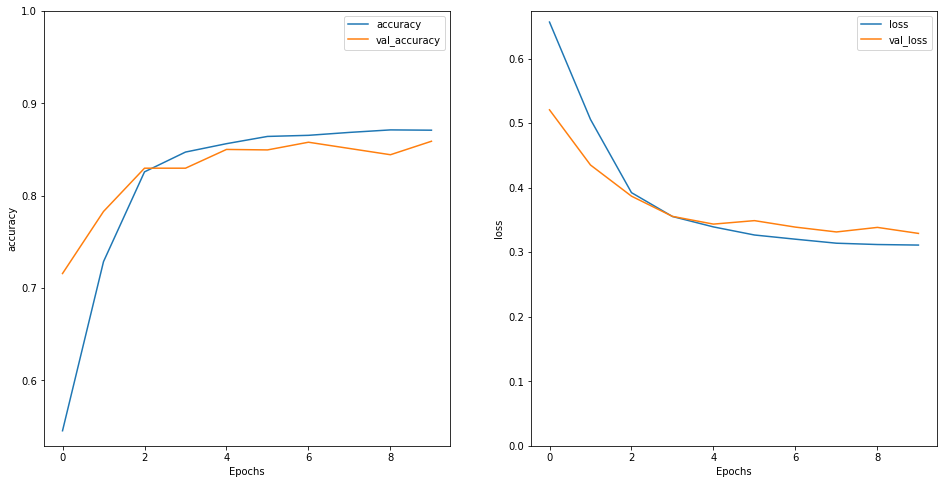

In [164]:
make_plot(history_base_temp)

### Model storage size and summary

In [194]:
model_base_temp.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_15 (Embedding)     (None, None, 64)          64000     
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 128)               66048     
_________________________________________________________________
dense_30 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 65        
Total params: 138,369
Trainable params: 138,369
Non-trainable params: 0
_______________________________________________

In [166]:
model_base_temp.save('drive/MyDrive/GaTech/big_data/model_base_temp')

INFO:tensorflow:Assets written to: drive/MyDrive/GaTech/big_data/model_base_temp/assets


INFO:tensorflow:Assets written to: drive/MyDrive/GaTech/big_data/model_base_temp/assets


In [167]:
!du -hsx drive/MyDrive/GaTech/big_data/model_base_temp

8.5M	drive/MyDrive/GaTech/big_data/model_base_temp


### Stacked LSTM

In [121]:
model_stk_temp = tf.keras.Sequential([
encoder,
tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1)
])

In [122]:
model_stk_temp.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [123]:
start_time = time.time()

history_temp = model_stk_temp.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

end_time = time.time()

mins = (end_time-start_time)/60
secs = (end_time-start_time)%60

print("Time taken to train: {} minutes and {} seconds".format(mins, secs))

Epoch 1/10
391/391 [==============================] - 74s 152ms/step - loss: 0.6267 - accuracy: 0.5838 - val_loss: 0.4444 - val_accuracy: 0.7766
Epoch 2/10
391/391 [==============================] - 56s 141ms/step - loss: 0.3935 - accuracy: 0.8261 - val_loss: 0.3533 - val_accuracy: 0.8490
Epoch 3/10
391/391 [==============================] - 55s 140ms/step - loss: 0.3417 - accuracy: 0.8543 - val_loss: 0.3337 - val_accuracy: 0.8547
Epoch 4/10
391/391 [==============================] - 56s 142ms/step - loss: 0.3221 - accuracy: 0.8635 - val_loss: 0.3224 - val_accuracy: 0.8578
Epoch 5/10
391/391 [==============================] - 56s 141ms/step - loss: 0.3166 - accuracy: 0.8641 - val_loss: 0.3194 - val_accuracy: 0.8594
Epoch 6/10
391/391 [==============================] - 55s 140ms/step - loss: 0.3076 - accuracy: 0.8689 - val_loss: 0.3280 - val_accuracy: 0.8500
Epoch 7/10
391/391 [==============================] - 55s 140ms/step - loss: 0.3030 - accuracy: 0.8695 - val_loss: 0.3174 - val_ac

In [124]:
test_model(model_stk_temp)

391/391 [==============================] - 29s 75ms/step - loss: 0.3150 - accuracy: 0.8620
Time taken to test: 0.4872897903124491 minutes and 29.23738741874695 seconds
Test Loss: 0.31498581171035767
Test Accuracy: 0.8619599938392639


### Confusion Matrix

In [153]:
get_confusion_matrix(model_stk_temp)

[[10729  1771]
 [ 1585 10915]]


### Train and Validation Plot

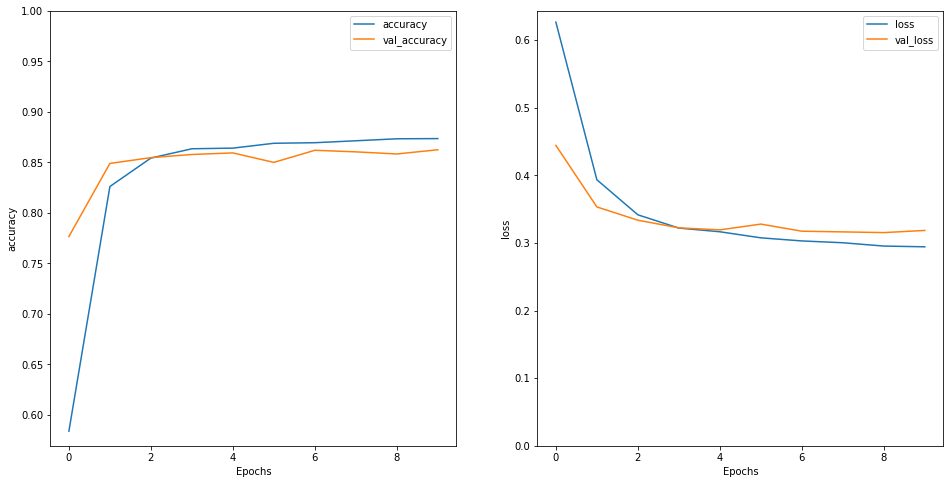

In [154]:
make_plot(history_temp)

### Model storage size and summary

In [168]:
model_stk_temp.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_9 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_14 (Bidirectio (None, None, 128)         66048     
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

In [149]:
model_stk_temp.save('drive/MyDrive/GaTech/big_data/model_stk_temp')

INFO:tensorflow:Assets written to: drive/MyDrive/GaTech/big_data/model_stk_temp/assets


INFO:tensorflow:Assets written to: drive/MyDrive/GaTech/big_data/model_stk_temp/assets


In [169]:
!du -hsx drive/MyDrive/GaTech/big_data/model_stk_temp

16M	drive/MyDrive/GaTech/big_data/model_stk_temp


### Model with 0.01 LR

In [129]:
model_stk_lr_temp = tf.keras.Sequential([
encoder,
tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1)
])

In [130]:
model_stk_lr_temp.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=['accuracy'])

In [131]:
start_time = time.time()

history_stk_lr_temp = model_stk_lr_temp.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

end_time = time.time()

mins = (end_time-start_time)/60
secs = (end_time-start_time)%60

print("Time taken to train: {} minutes and {} seconds".format(mins, secs))

Epoch 1/10
391/391 [==============================] - 70s 149ms/step - loss: 0.6310 - accuracy: 0.5875 - val_loss: 0.4571 - val_accuracy: 0.8052
Epoch 2/10
391/391 [==============================] - 55s 139ms/step - loss: 0.4036 - accuracy: 0.8158 - val_loss: 0.3491 - val_accuracy: 0.8438
Epoch 3/10
391/391 [==============================] - 55s 138ms/step - loss: 0.3385 - accuracy: 0.8506 - val_loss: 0.3390 - val_accuracy: 0.8411
Epoch 4/10
391/391 [==============================] - 55s 139ms/step - loss: 0.3183 - accuracy: 0.8594 - val_loss: 0.3393 - val_accuracy: 0.8438
Epoch 5/10
391/391 [==============================] - 55s 139ms/step - loss: 0.2953 - accuracy: 0.8738 - val_loss: 0.3415 - val_accuracy: 0.8458
Epoch 6/10
391/391 [==============================] - 55s 139ms/step - loss: 0.2861 - accuracy: 0.8775 - val_loss: 0.3518 - val_accuracy: 0.8432
Epoch 7/10
391/391 [==============================] - 55s 140ms/step - loss: 0.2733 - accuracy: 0.8840 - val_loss: 0.3627 - val_ac

In [132]:
test_model(model_stk_lr_temp)

391/391 [==============================] - 29s 74ms/step - loss: 0.3467 - accuracy: 0.8613
Time taken to test: 0.4834386984507243 minutes and 29.006321907043457 seconds
Test Loss: 0.3466644287109375
Test Accuracy: 0.8613200187683105


### Confusion Matrix

In [182]:
get_confusion_matrix(model_stk_lr_temp)

[[10408  2092]
 [ 1371 11129]]


### Train and Validation Plot

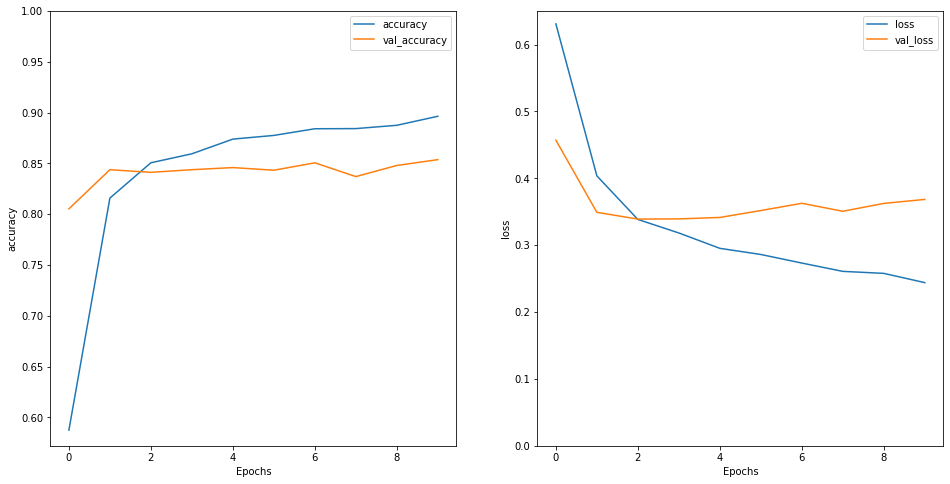

In [171]:
make_plot(history_stk_lr_temp)

### Model storage size and summary

In [172]:
model_stk_lr_temp.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_11 (Embedding)     (None, None, 64)          64000     
_________________________________________________________________
bidirectional_18 (Bidirectio (None, None, 128)         66048     
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)               

In [150]:
model_stk_lr_temp.save('drive/MyDrive/GaTech/big_data/model_stk_lr_temp')

INFO:tensorflow:Assets written to: drive/MyDrive/GaTech/big_data/model_stk_lr_temp/assets


INFO:tensorflow:Assets written to: drive/MyDrive/GaTech/big_data/model_stk_lr_temp/assets


In [173]:
!du -hsx drive/MyDrive/GaTech/big_data/model_stk_lr_temp

16M	drive/MyDrive/GaTech/big_data/model_stk_lr_temp


### Model with 128 Encoding dim

In [206]:
model_stk_enc_temp_1 = tf.keras.Sequential([
encoder,
tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1)
])

In [207]:
model_stk_enc_temp_1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [208]:
start_time = time.time()

history_stk_enc_temp_1 = model_stk_enc_temp_1.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

end_time = time.time()

mins = (end_time-start_time)/60
secs = (end_time-start_time)%60

print("Time taken to train: {} minutes and {} seconds".format(mins, secs))

Epoch 1/10
391/391 [==============================] - 72s 153ms/step - loss: 0.6288 - accuracy: 0.5826 - val_loss: 0.4526 - val_accuracy: 0.8062
Epoch 2/10
391/391 [==============================] - 57s 146ms/step - loss: 0.3870 - accuracy: 0.8302 - val_loss: 0.3491 - val_accuracy: 0.8427
Epoch 3/10
391/391 [==============================] - 57s 143ms/step - loss: 0.3366 - accuracy: 0.8566 - val_loss: 0.3342 - val_accuracy: 0.8391
Epoch 4/10
391/391 [==============================] - 57s 144ms/step - loss: 0.3189 - accuracy: 0.8637 - val_loss: 0.3390 - val_accuracy: 0.8292
Epoch 5/10
391/391 [==============================] - 56s 143ms/step - loss: 0.3109 - accuracy: 0.8677 - val_loss: 0.3334 - val_accuracy: 0.8354
Epoch 6/10
391/391 [==============================] - 57s 144ms/step - loss: 0.3032 - accuracy: 0.8705 - val_loss: 0.3355 - val_accuracy: 0.8583
Epoch 7/10
391/391 [==============================] - 56s 143ms/step - loss: 0.3011 - accuracy: 0.8723 - val_loss: 0.3249 - val_ac

In [209]:
test_model(model_stk_enc_temp_1)

391/391 [==============================] - 30s 77ms/step - loss: 0.3209 - accuracy: 0.8634
Time taken to test: 0.5025822202364604 minutes and 30.154933214187622 seconds
Test Loss: 0.3208688199520111
Test Accuracy: 0.8633999824523926


### Confusion Matrix

In [210]:
get_confusion_matrix(model_stk_enc_temp_1)

[[10664  1836]
 [ 1544 10956]]


### Train and Validation Plot

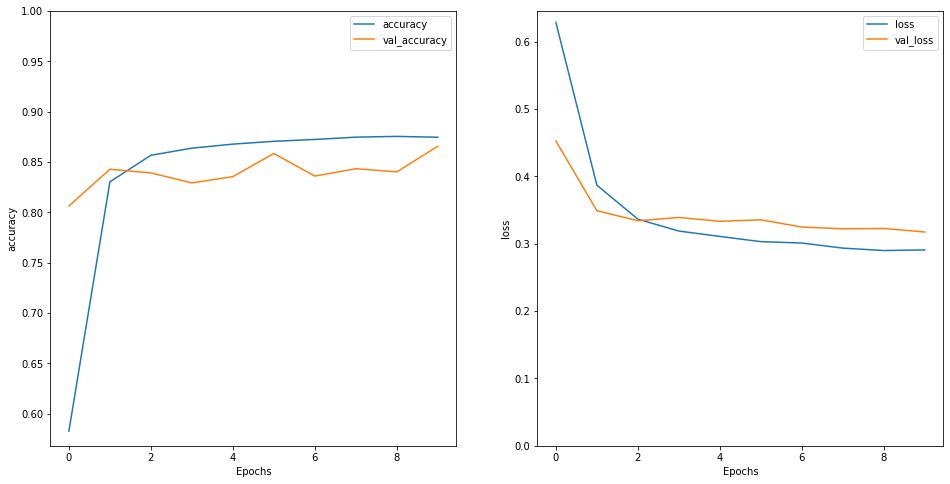

In [225]:
make_plot(history_stk_enc_temp_1)

### Model storage size and summary

In [212]:
model_stk_enc_temp_1.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_19 (Embedding)     (None, None, 128)         128000    
_________________________________________________________________
bidirectional_31 (Bidirectio (None, None, 128)         98816     
_________________________________________________________________
bidirectional_32 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)               

In [213]:
model_stk_enc_temp_1.save('drive/MyDrive/GaTech/big_data/model_stk_enc_temp_1')

INFO:tensorflow:Assets written to: drive/MyDrive/GaTech/big_data/model_stk_enc_temp_1/assets


INFO:tensorflow:Assets written to: drive/MyDrive/GaTech/big_data/model_stk_enc_temp_1/assets


In [214]:
!du -hsx drive/MyDrive/GaTech/big_data/model_stk_enc_temp_1

17M	drive/MyDrive/GaTech/big_data/model_stk_enc_temp_1


### Model with 128 Enc dim and 0.01 LR

In [215]:
model_stk_enc_lr_temp_1 = tf.keras.Sequential([
encoder,
tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1)
])

In [216]:
model_stk_enc_lr_temp_1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=['accuracy'])

In [217]:
start_time = time.time()

history_stk_enc_lr_temp_1 = model_stk_enc_lr_temp_1.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

end_time = time.time()

mins = (end_time-start_time)/60
secs = (end_time-start_time)%60

print("Time taken to train: {} minutes and {} seconds".format(mins, secs))

Epoch 1/10
391/391 [==============================] - 73s 154ms/step - loss: 0.5592 - accuracy: 0.6841 - val_loss: 0.4085 - val_accuracy: 0.8161
Epoch 2/10
391/391 [==============================] - 57s 144ms/step - loss: 0.3801 - accuracy: 0.8286 - val_loss: 0.3617 - val_accuracy: 0.8031
Epoch 3/10
391/391 [==============================] - 57s 145ms/step - loss: 0.3311 - accuracy: 0.8515 - val_loss: 0.3481 - val_accuracy: 0.8411
Epoch 4/10
391/391 [==============================] - 57s 144ms/step - loss: 0.3127 - accuracy: 0.8592 - val_loss: 0.3331 - val_accuracy: 0.8417
Epoch 5/10
391/391 [==============================] - 58s 146ms/step - loss: 0.2911 - accuracy: 0.8746 - val_loss: 0.3219 - val_accuracy: 0.8599
Epoch 6/10
391/391 [==============================] - 57s 144ms/step - loss: 0.2754 - accuracy: 0.8800 - val_loss: 0.3380 - val_accuracy: 0.8620
Epoch 7/10
391/391 [==============================] - 56s 143ms/step - loss: 0.2686 - accuracy: 0.8837 - val_loss: 0.3109 - val_ac

In [218]:
test_model(model_stk_enc_lr_temp_1)

391/391 [==============================] - 30s 75ms/step - loss: 0.3343 - accuracy: 0.8581
Time taken to test: 0.49233694473902384 minutes and 29.54021668434143 seconds
Test Loss: 0.3342568874359131
Test Accuracy: 0.8580800294876099


### Confusion Matrix

In [219]:
get_confusion_matrix(model_stk_enc_lr_temp_1)

[[11235  1265]
 [ 2076 10424]]


### Train and Validation Plot

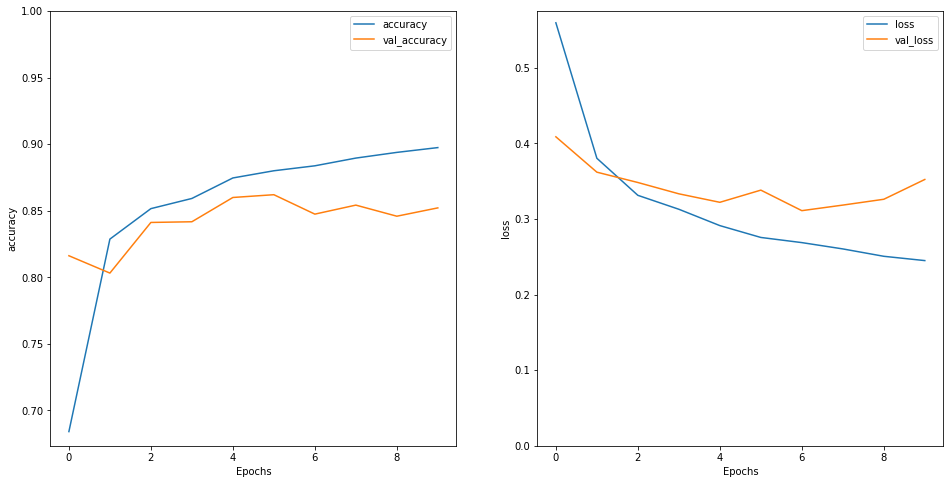

In [220]:
make_plot(history_stk_enc_lr_temp_1)

### Model storage size and summary

In [221]:
model_stk_enc_lr_temp_1.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_20 (Embedding)     (None, None, 128)         128000    
_________________________________________________________________
bidirectional_33 (Bidirectio (None, None, 128)         98816     
_________________________________________________________________
bidirectional_34 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_40 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)               

In [222]:
model_stk_enc_lr_temp_1.save('drive/MyDrive/GaTech/big_data/model_stk_enc_lr_temp_1')

INFO:tensorflow:Assets written to: drive/MyDrive/GaTech/big_data/model_stk_enc_lr_temp_1/assets


INFO:tensorflow:Assets written to: drive/MyDrive/GaTech/big_data/model_stk_enc_lr_temp_1/assets


In [224]:
!du -hsx drive/MyDrive/GaTech/big_data/model_stk_enc_lr_temp_1

17M	drive/MyDrive/GaTech/big_data/model_stk_enc_lr_temp_1


### Dropout Model

In [195]:
model_drop_temp = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])  # Can change the embedding initializer and in fact
    #all the other hyperparameters in the various layers

In [196]:
model_drop_temp.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [197]:
start_time = time.time()

history_drop_temp = model_drop_temp.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

end_time = time.time()

mins = (end_time-start_time)/60
secs = (end_time-start_time)%60

print("Time taken to train: {} minutes and {} seconds".format(mins, secs))

Epoch 1/10
391/391 [==============================] - 43s 93ms/step - loss: 0.6396 - accuracy: 0.5816 - val_loss: 0.5007 - val_accuracy: 0.7781
Epoch 2/10
391/391 [==============================] - 34s 86ms/step - loss: 0.4493 - accuracy: 0.7852 - val_loss: 0.4649 - val_accuracy: 0.7505
Epoch 3/10
391/391 [==============================] - 35s 87ms/step - loss: 0.3737 - accuracy: 0.8344 - val_loss: 0.3613 - val_accuracy: 0.8469
Epoch 4/10
391/391 [==============================] - 35s 87ms/step - loss: 0.3350 - accuracy: 0.8529 - val_loss: 0.3381 - val_accuracy: 0.8589
Epoch 5/10
391/391 [==============================] - 34s 86ms/step - loss: 0.3223 - accuracy: 0.8587 - val_loss: 0.3278 - val_accuracy: 0.8552
Epoch 6/10
391/391 [==============================] - 34s 87ms/step - loss: 0.3108 - accuracy: 0.8667 - val_loss: 0.3217 - val_accuracy: 0.8615
Epoch 7/10
391/391 [==============================] - 34s 87ms/step - loss: 0.3058 - accuracy: 0.8690 - val_loss: 0.3242 - val_accuracy:

In [198]:
test_model(model_drop_temp)

391/391 [==============================] - 20s 50ms/step - loss: 0.3178 - accuracy: 0.8622
Time taken to test: 0.32717066605885825 minutes and 19.630239963531494 seconds
Test Loss: 0.3178006112575531
Test Accuracy: 0.8622400164604187


### Confusion Matrix

In [199]:
get_confusion_matrix(model_drop_temp)

[[10700  1800]
 [ 1604 10896]]


### Train and Validation Plot

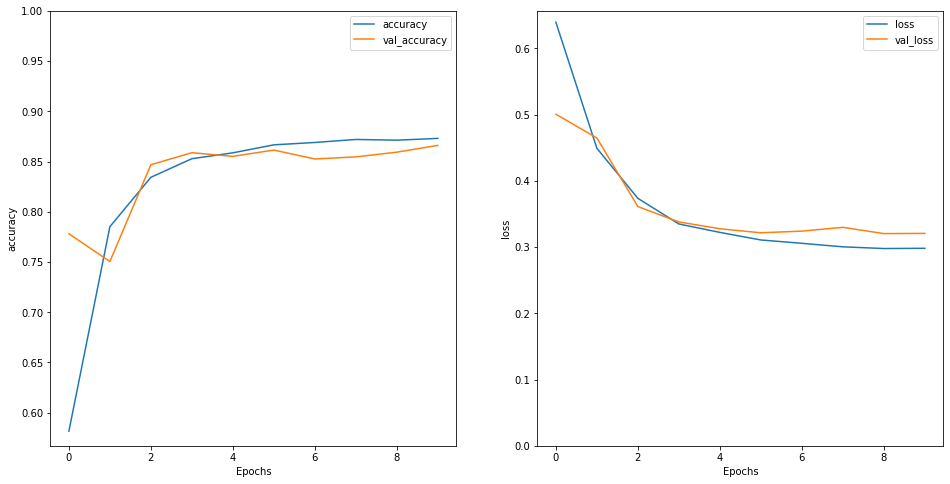

In [200]:
make_plot(history_drop_temp)

### Model storage size and summary

In [ ]:
model_drop_temp.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_15 (Embedding)     (None, None, 64)          64000     
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 128)               66048     
_________________________________________________________________
dense_30 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 65        
Total params: 138,369
Trainable params: 138,369
Non-trainable params: 0
_______________________________________________

In [ ]:
model_base_temp.save('drive/MyDrive/GaTech/big_data/model_base_temp')

INFO:tensorflow:Assets written to: drive/MyDrive/GaTech/big_data/model_base_temp/assets


INFO:tensorflow:Assets written to: drive/MyDrive/GaTech/big_data/model_base_temp/assets


In [ ]:
!du -hsx drive/MyDrive/GaTech/big_data/model_base_temp

8.5M	drive/MyDrive/GaTech/big_data/model_base_temp
